In [ ]:
!pip install -q scanpy[louvain] lifelines
!pip install -U matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from lifelines import KaplanMeierFitter, CoxPHFitter
from scipy.stats import mannwhitneyu
from pathlib import Path
from google.colab import drive

In [ ]:
drive.mount("/content/drive")
DATA = Path("/content/drive/My Drive/ecbm_4060") # change to be correct data dir

sc.settings.set_figure_params(dpi=40)
sc.set_figure_params(scanpy=True, fontsize=24)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
a_adata = sc.read_h5ad(DATA / "GSE189125A.h5ad")
b_adata = sc.read_h5ad(DATA / "GSE189125B.h5ad")

# Cluster analysis to check cell type annotations in the "A" cohort

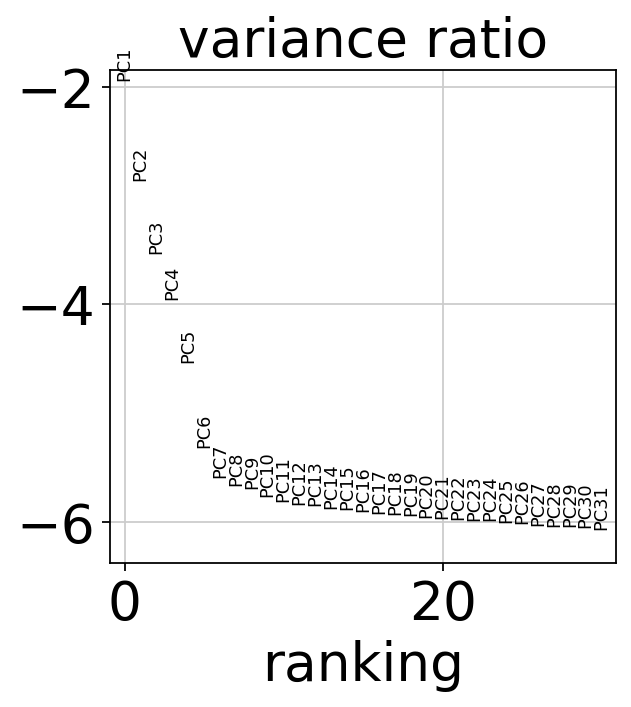

In [ ]:
sc.tl.pca(a_adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(a_adata, log=True)

/usr/local/lib/python3.8/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


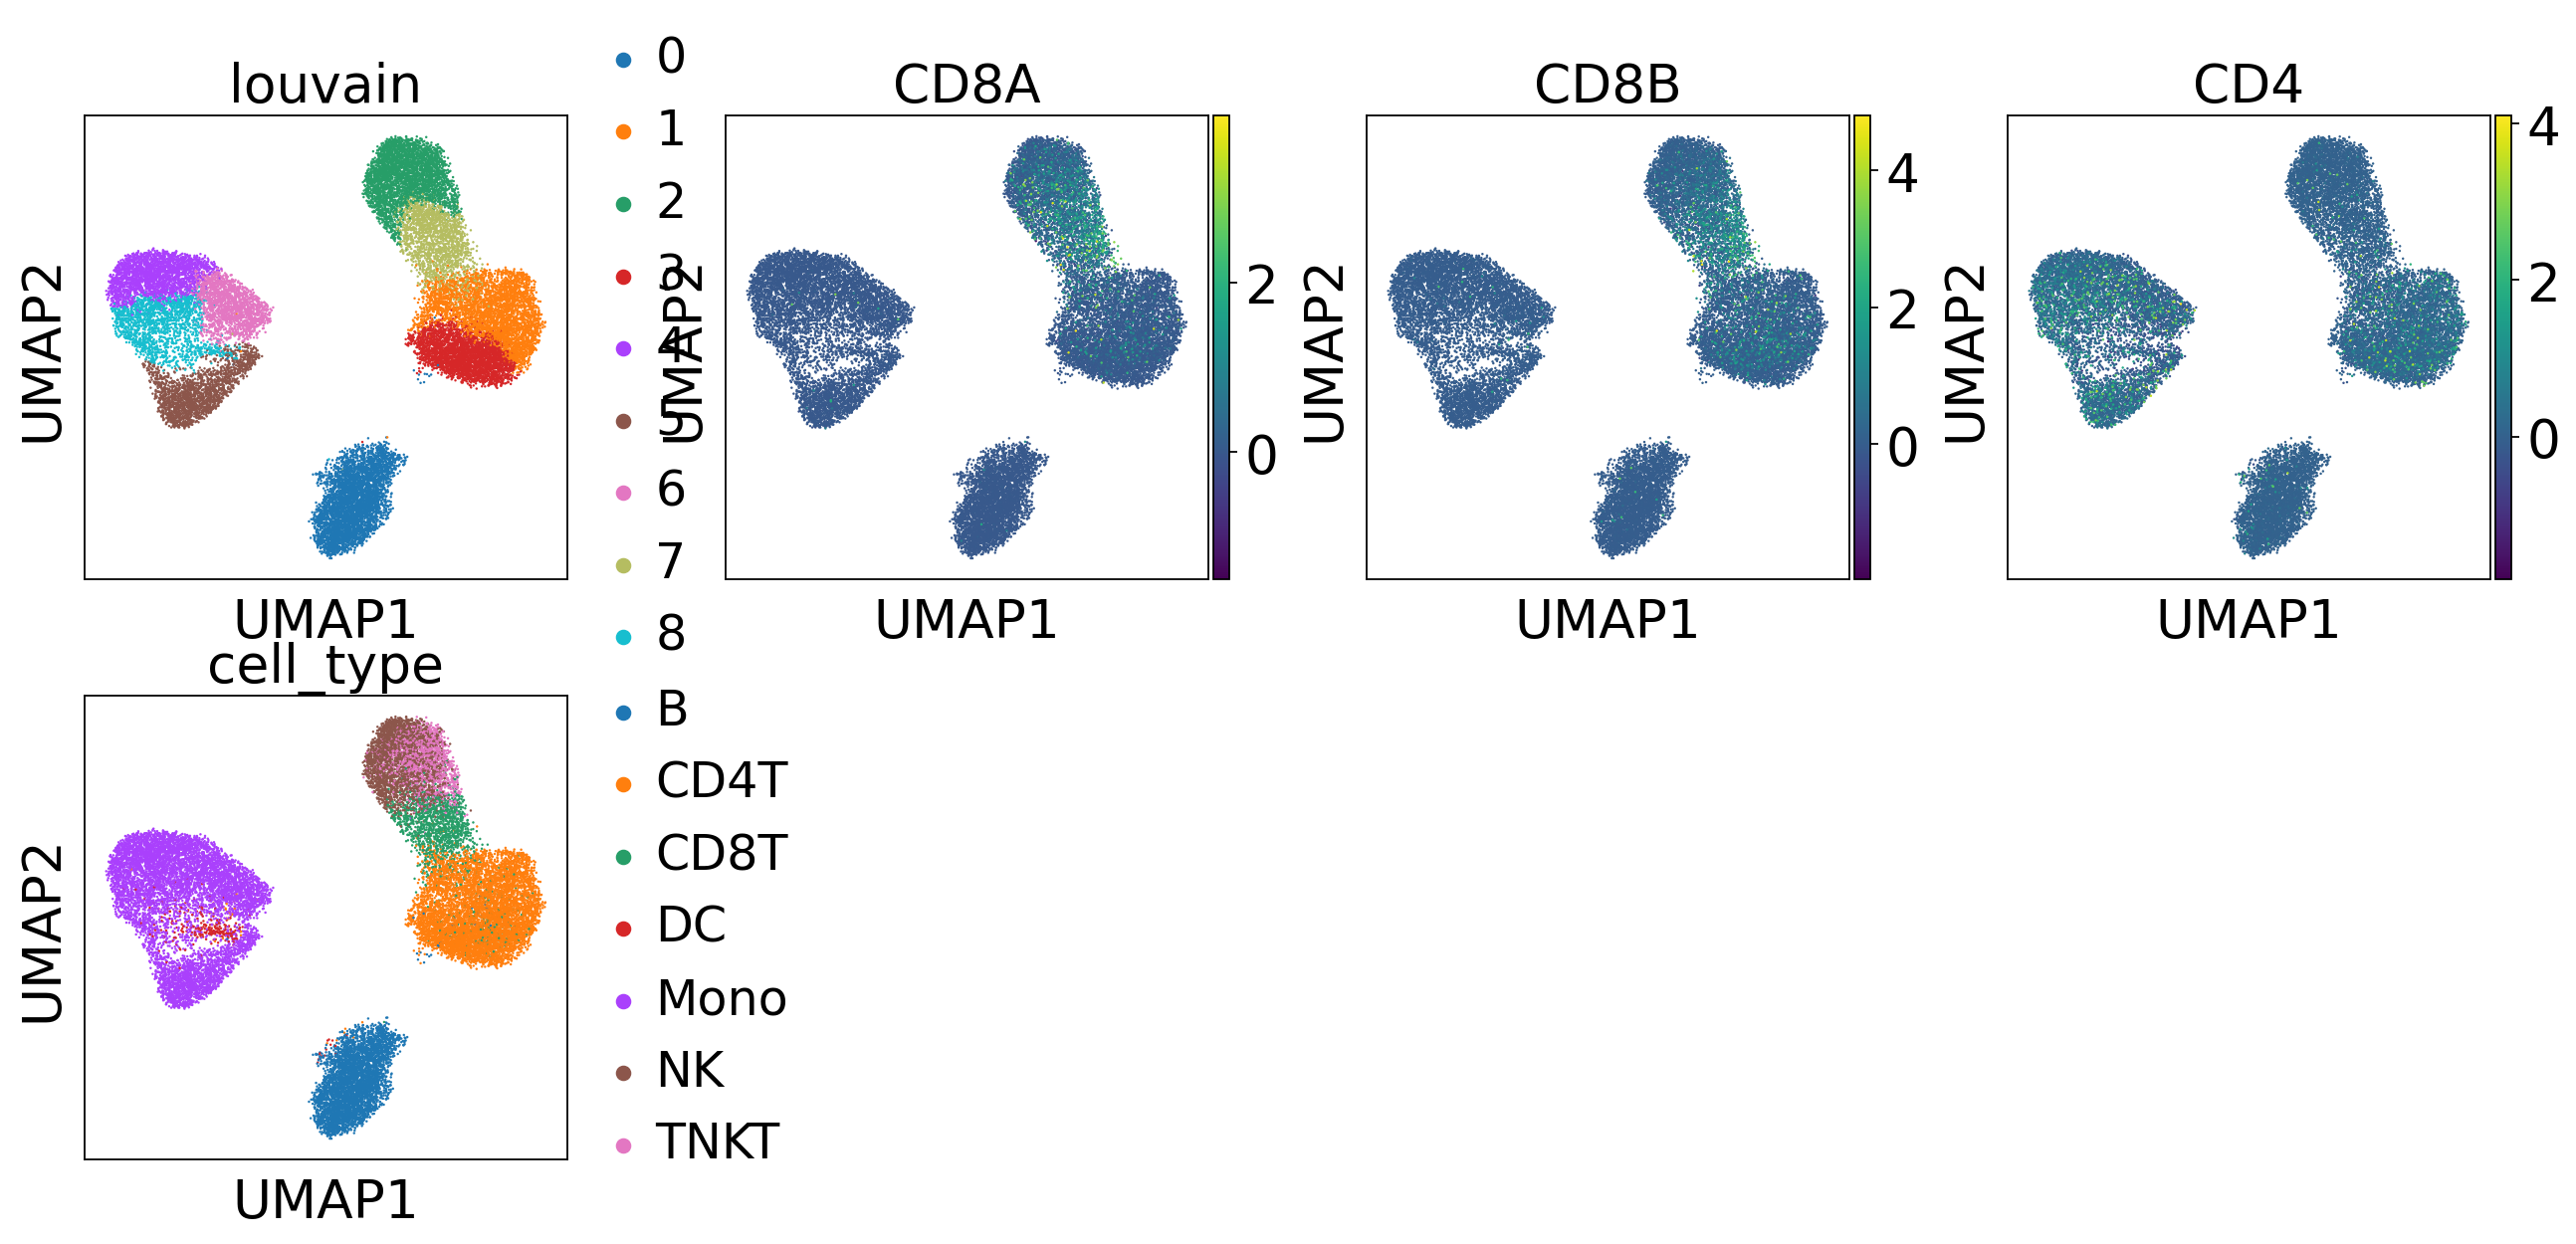

In [ ]:
sc.pp.neighbors(a_adata, n_pcs=16, random_state=0)
sc.tl.umap(a_adata, random_state=0)
sc.tl.louvain(a_adata, random_state=0)
sc.pl.umap(a_adata, color=["louvain", "CD8A", "CD8B", "CD4", "cell_type"])

categories: B, CD4T, CD8T, etc.
var_group_labels: CD4, CD8


/usr/local/lib/python3.8/dist-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


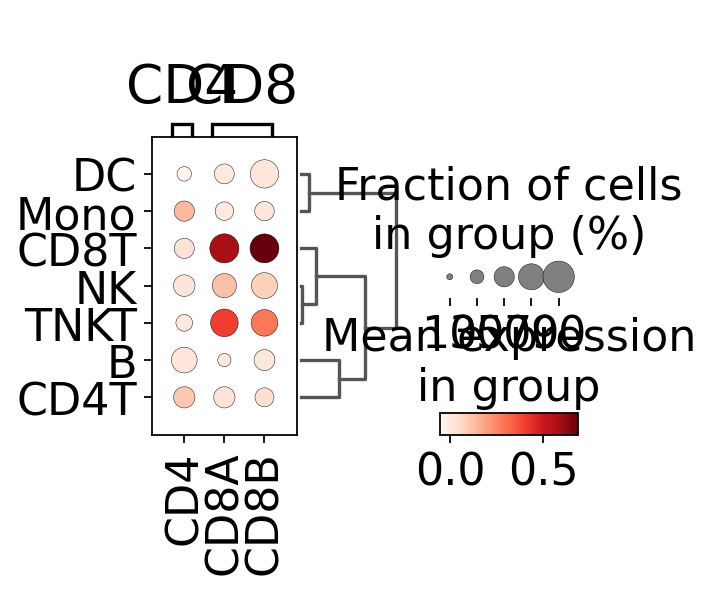

In [ ]:
sc.tl.dendrogram(a_adata, groupby="cell_type")
marker_genes = {
    'CD4': ['CD4'], # CD4 T cell
    'CD8': ['CD8A', 'CD8B'], # CD8 T cell
}

sc.pl.dotplot(a_adata, marker_genes, groupby="cell_type", dendrogram=True)

In [ ]:
a_adata = a_adata[a_adata.obs.cell_type.isin(["CD8T", "TNKT"])]
a_adata

View of AnnData object with n_obs × n_vars = 2915 × 2000
    obs: 'cell', 'ptid', 'cell_type', 'louvain'
    var: 'gene'
    uns: 'pca', 'neighbors', 'umap', 'louvain', 'louvain_colors', 'cell_type_colors', 'dendrogram_cell_type'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

# Cluster and annotate "B" cohort

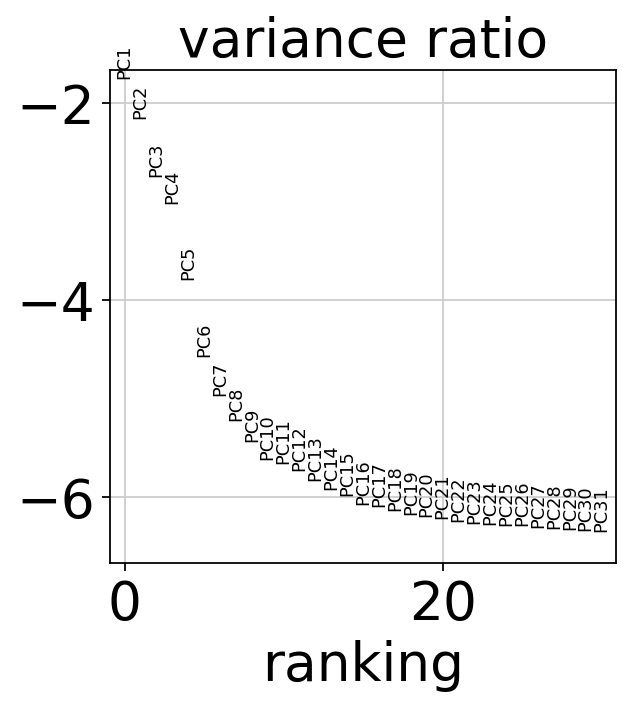

In [ ]:
sc.tl.pca(b_adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(b_adata, log=True)

/usr/local/lib/python3.8/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


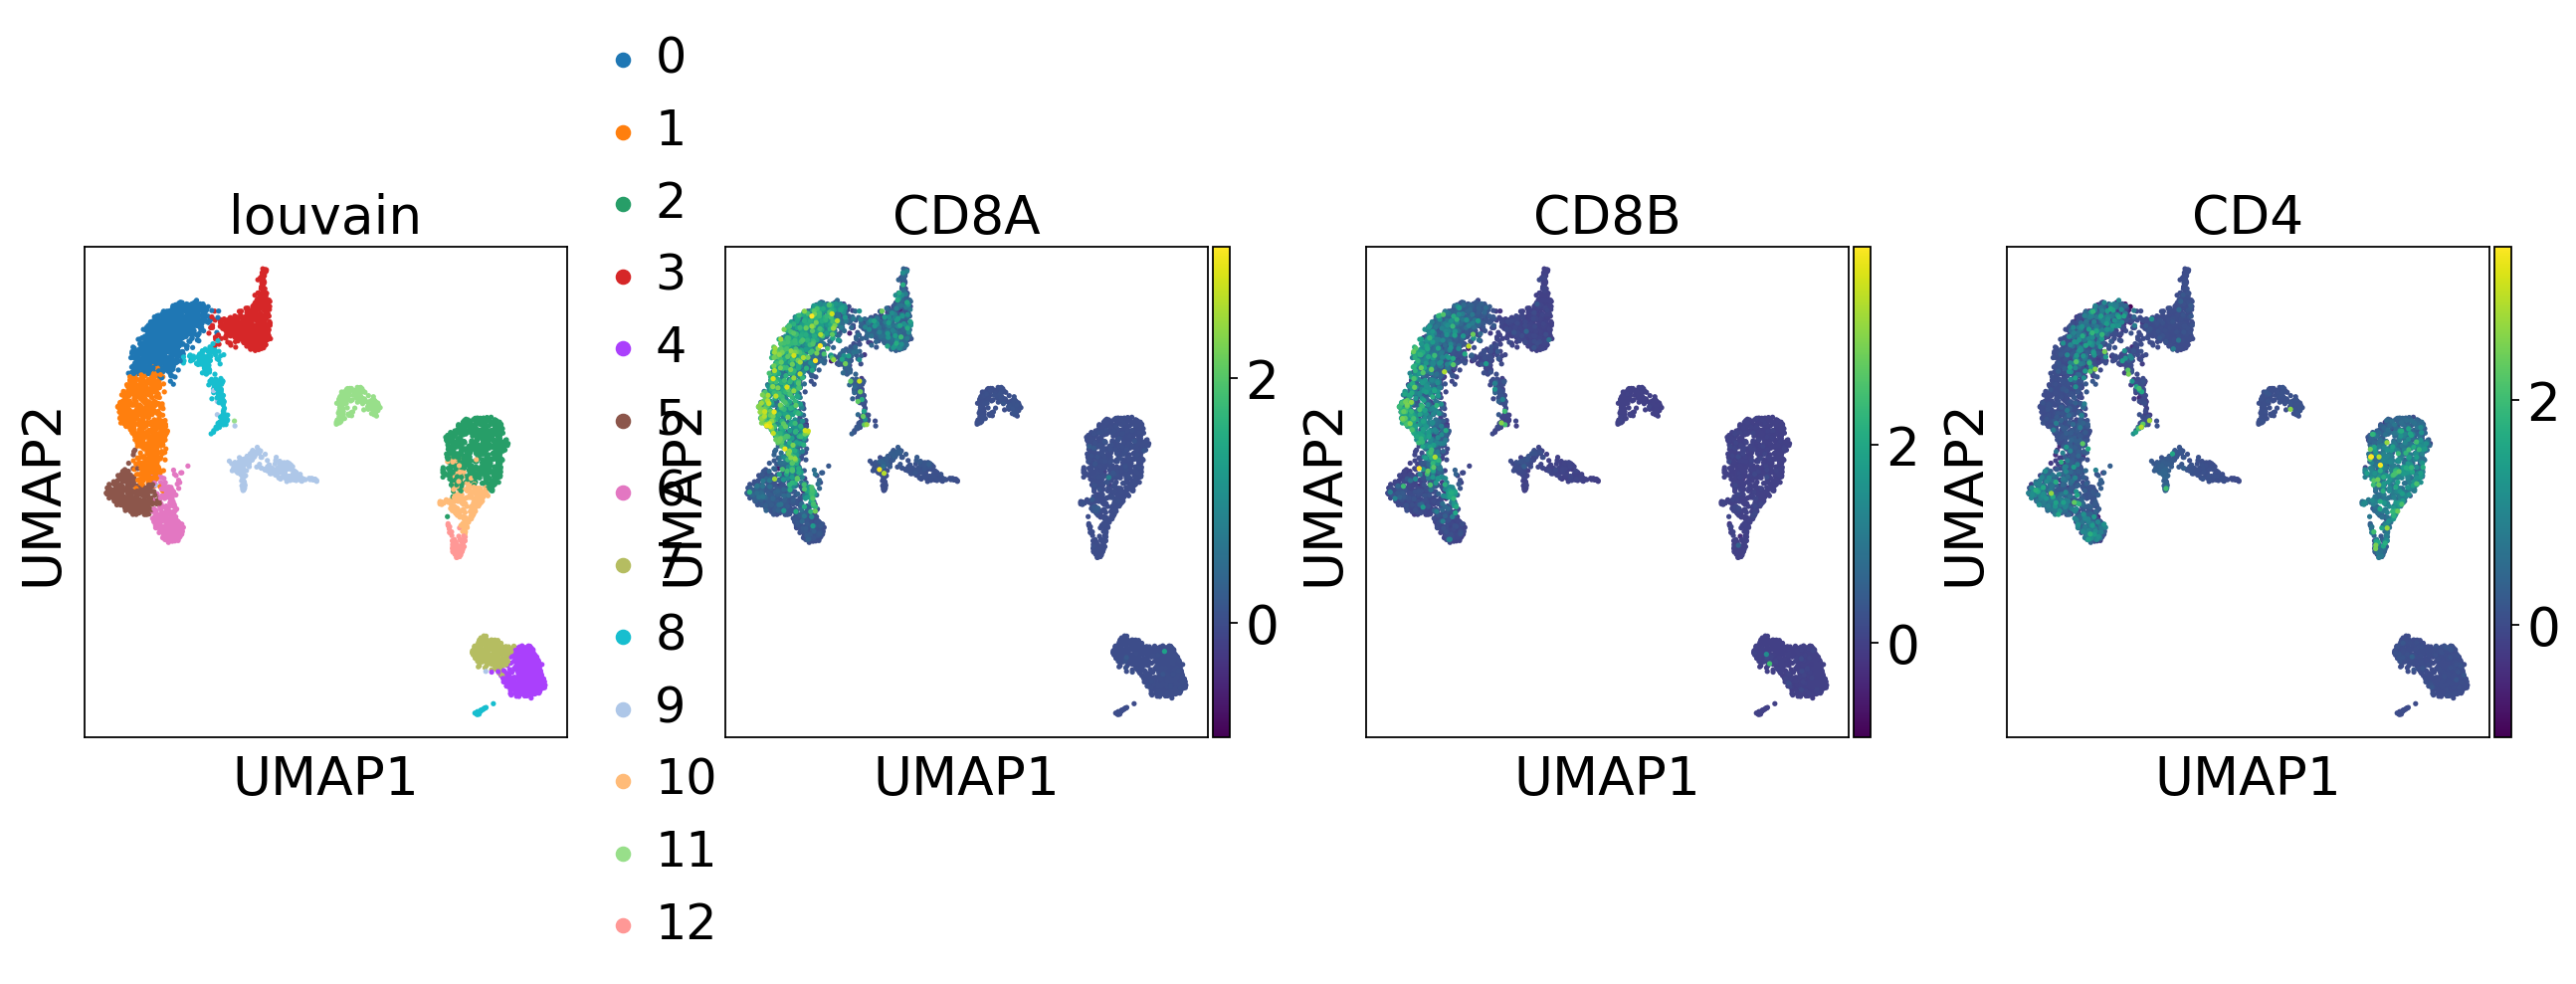

In [ ]:
sc.pp.neighbors(b_adata, n_pcs=22, random_state=0)
sc.tl.umap(b_adata, random_state=0)
sc.tl.louvain(b_adata, random_state=0)
sc.pl.umap(b_adata, color=["louvain", "CD8A", "CD8B", "CD4"])

categories: 0, 1, 2, etc.
var_group_labels: CD4, CD8


/usr/local/lib/python3.8/dist-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


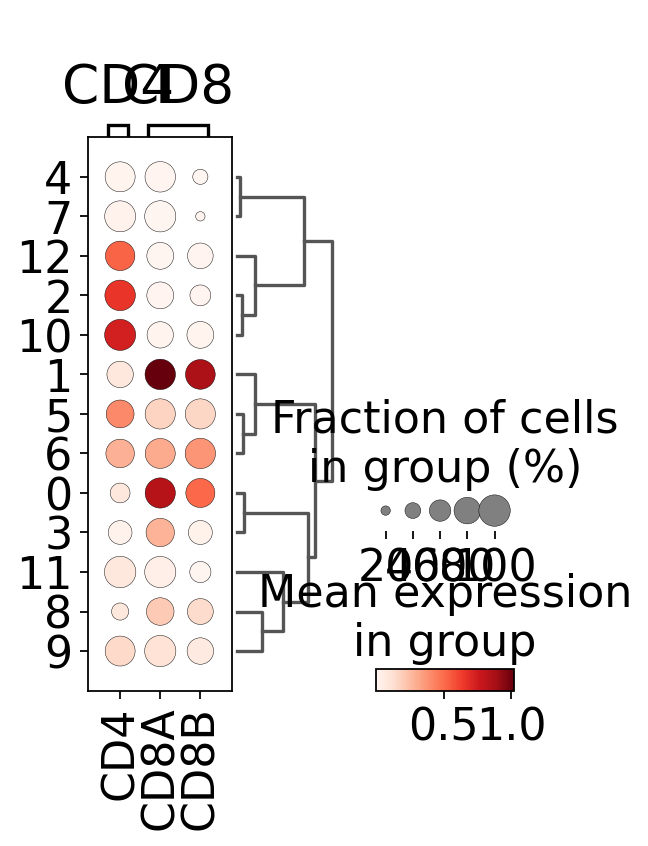

In [ ]:
sc.tl.dendrogram(b_adata, groupby="louvain")
sc.pl.dotplot(b_adata, marker_genes, groupby="louvain", dendrogram=True)

In [ ]:
b_adata = b_adata[b_adata.obs.louvain.isin(["0", "1"])]
b_adata = b_adata[~b_adata.obs.ptid.isin(["YUHONEY"])]
b_adata

View of AnnData object with n_obs × n_vars = 1123 × 2000
    obs: 'cell', 'ptid', 'louvain'
    var: 'gene'
    uns: 'pca', 'neighbors', 'umap', 'louvain', 'louvain_colors', 'dendrogram_louvain'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

# Check that overall expression of TOX does not depend on cohort

In [ ]:
print(np.median(a_adata[:, "TOX"].X.ravel()))
print(np.median(b_adata[:, "TOX"].X.ravel()))

0.055131964
0.017756227


In [ ]:
mannwhitneyu(a_adata[:, "TOX"].X.ravel(), b_adata[:, "TOX"].X.ravel())

MannwhitneyuResult(statistic=2008863.0, pvalue=3.522497518375581e-29)

It appears that TOX expression might be different scaled across the two datasets. Since cohort B only includes 2 usable patients out of the 15 total, we will just drop the data from consideration to avoid confounding.

# Clinical outcome analysis

In [ ]:
clinical_df = pd.read_csv(DATA / "clinical_melanoma.csv", index_col=0)
clinical_df

,age,sex,type,treatment,prior_treatment,ae_grade,severe_ae,time_to_event,site,gi,response
ptid,,,,,,,,,,,
YUCARD,77,Male,Indeterminate,Combination,No,3,1,1.41,GI,1,DCB
YUTAUR,72,Male,Acral,Combination,No,3,1,0.39,skin,0,NDB
YUPIXEL,76,Male,Sun-exposed,Combination,No,3,1,1.61,lung,0,DCB
YUVARDO,75,Male,Sun-exposed,Combination,No,3,1,1.15,GI,1,DCB
YUFURL,74,Male,Mucosal,Combination,No,3,1,1.41,GI,1,NDB
YUTORY,84,Male,Ocular/Uveal,Combination,No,3,1,0.59,systemic,0,NDB
YUALOE,66,Male,Sun-exposed,Combination,No,3,1,2.30,pancreas,0,DCB
YUNANCY,41,Female,Sun-exposed,Combination,No,3,1,0.59,liver,0,DCB
YUHERN,53,Female,Mucosal,Combination,No,2,0,43.96,"joint, systemic",0,DCB


In [ ]:
tox_df = sc.get.obs_df(
    a_adata,
    keys=["TOX", "ptid"]
)
tox_df = tox_df.groupby("ptid").mean()
tox_df

,TOX
ptid,
YUCARD,0.103461
YUENZO,0.075134
YUFUB,0.109924
YUFURL,0.097130
YUGRUS,0.117997
YUHERN,0.081652
YUKEND,0.141426
YUPIXEL,0.080928
YUROD,0.115060


In [ ]:
tox_threshold = np.percentile(tox_df.TOX, 70)
tox_threshold

0.11623505055904387

In [ ]:
tox_df = tox_df.join(clinical_df)
tox_df["high_tox"] = (tox_df["TOX"] > tox_threshold)
tox_df["event"] = (tox_df["response"] != "DCB")

tox_df

,TOX,age,sex,type,treatment,prior_treatment,ae_grade,severe_ae,time_to_event,site,gi,response,high_tox,event
ptid,,,,,,,,,,,,,,
YUCARD,0.103461,77,Male,Indeterminate,Combination,No,3,1,1.41,GI,1,DCB,False,False
YUENZO,0.075134,36,Male,Sun-exposed,Anti-PD1,No,1,0,16.10,thyroid,0,NDB,False,True
YUFUB,0.109924,39,Male,Indeterminate,Combination,No,0,0,13.34,NaN,0,NDB,False,True
YUFURL,0.097130,74,Male,Mucosal,Combination,No,3,1,1.41,GI,1,NDB,False,True
YUGRUS,0.117997,48,Female,Acral,Combination,No,2,0,25.20,pituitary,0,NE,True,True
YUHERN,0.081652,53,Female,Mucosal,Combination,No,2,0,43.96,"joint, systemic",0,DCB,False,False
YUKEND,0.141426,80,Female,Sun-exposed,Anti-PD1,No,0,0,18.37,NaN,0,NE,True,True
YUPIXEL,0.080928,76,Male,Sun-exposed,Combination,No,3,1,1.61,lung,0,DCB,False,False
YUROD,0.115060,31,Male,Mucosal,Combination,No,2,0,41.63,joint,0,DCB,False,False


In [ ]:
tox_df["event"][tox_df.high_tox == True]

ptid
YUGRUS     True
YUKEND     True
YUTAUR     True
YUTHEA    False
Name: event, dtype: bool

In [ ]:
cph = CoxPHFitter()
cph.fit(tox_df[["high_tox", "time_to_event", "event"]], duration_col='time_to_event', event_col='event')
cph.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
high_tox,0.296174,1.344704,0.775207,-1.223204,1.815552,0.294286,6.144464,0.0,0.382058,0.702418,0.509598


<AxesSubplot: xlabel='timeline'>

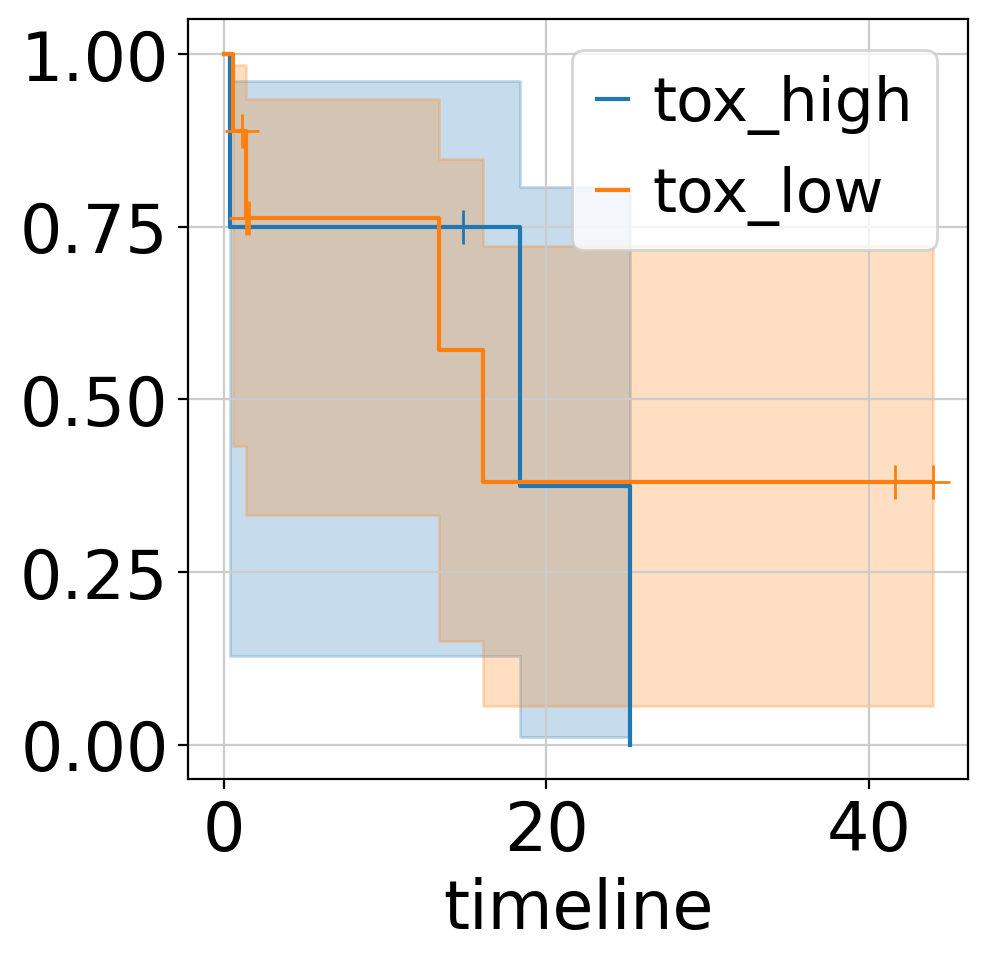

In [ ]:
kmf = KaplanMeierFitter()

fig, ax = plt.subplots(dpi=100, figsize=(5, 5))

tox_high_idx = tox_df["high_tox"]

kmf.fit(tox_df.time_to_event[tox_high_idx], tox_df.event[tox_high_idx],
        label="tox_high")
kmf.plot(ax=ax, show_censors=True)
kmf.fit(tox_df.time_to_event[~tox_high_idx], tox_df.event[~tox_high_idx],
        label="tox_low")
kmf.plot(ax=ax, show_censors=True)

# DEG Analysis by treatment response

In [ ]:
a_adata.obs["response"] = np.where(tox_df.loc[a_adata.obs.ptid.values, "event"].values, "no response", "response")

<ipython-input-87-11bc978c498c>:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  a_adata.obs["response"] = np.where(tox_df.loc[a_adata.obs.ptid.values, "event"].values, "no response", "response")


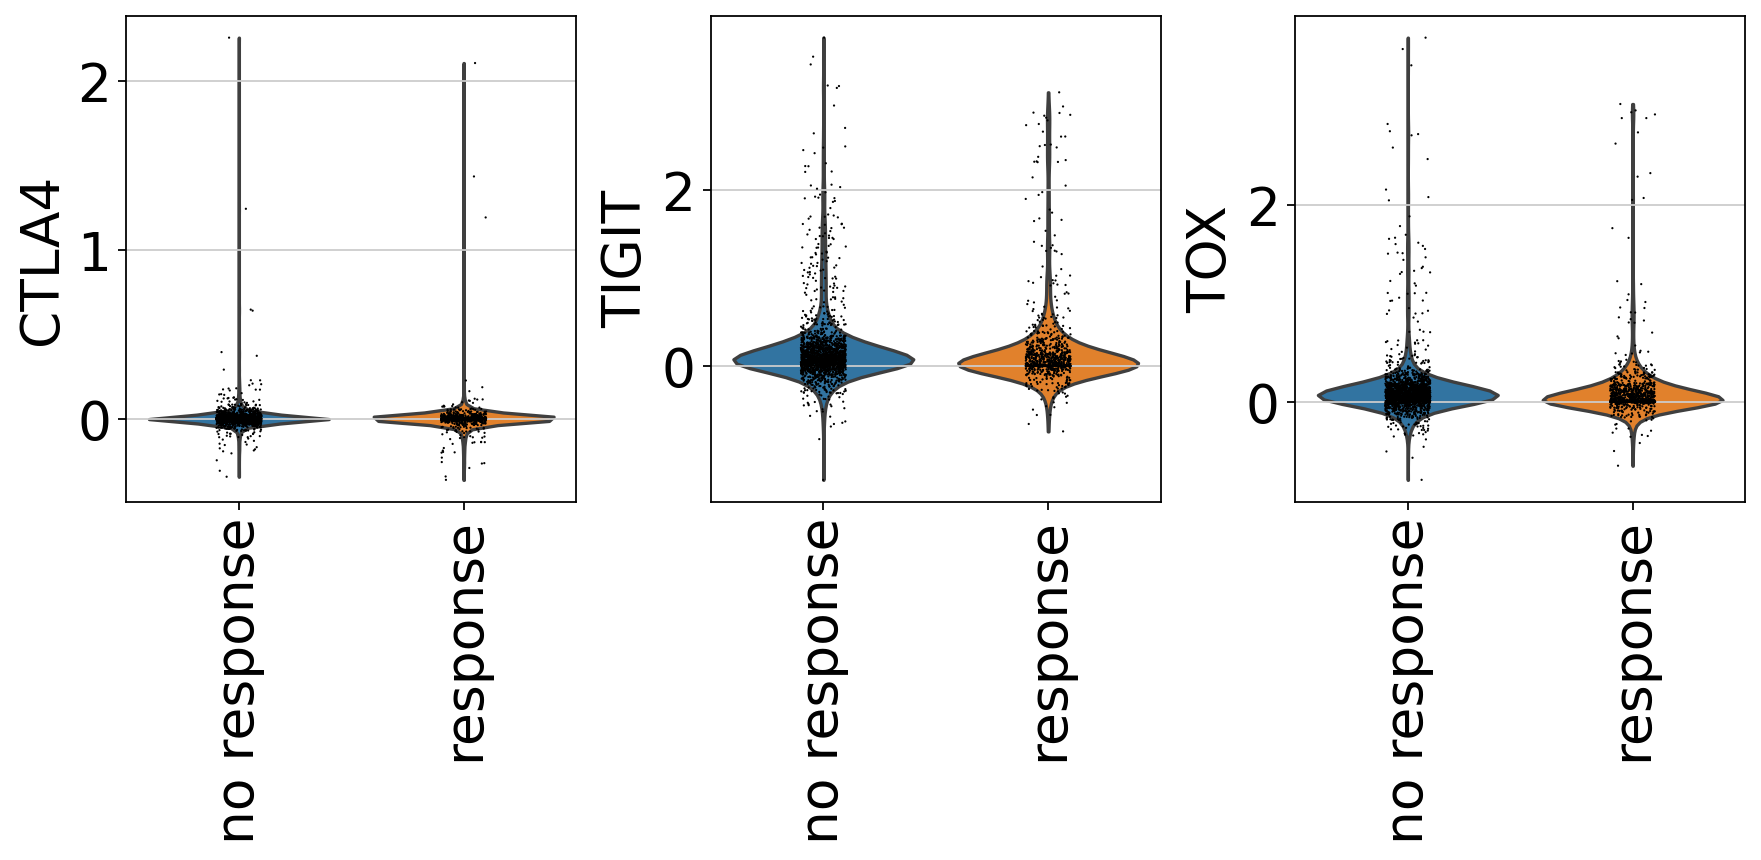

In [ ]:
sc.pl.violin(
    a_adata,
    keys=["CTLA4", "TIGIT", "TOX"],
    groupby="response",
    rotation=90,
    xlabel=""
)

In [ ]:
sc.tl.rank_genes_groups(a_adata, groupby="response", method="wilcoxon", use_raw=False)


In [ ]:
deg_names = [x for (x, _) in a_adata.uns["rank_genes_groups"]["names"]]
deg_p = [x for (x, _) in a_adata.uns["rank_genes_groups"]["pvals_adj"]]
deg_logfold = [x for (x, _) in a_adata.uns["rank_genes_groups"]["logfoldchanges"]]
degs = pd.DataFrame(data={
    "names": deg_names,
    "p_val": deg_p,
    "logfold": deg_logfold,
})
degs = degs[degs["p_val"] < 0.05]

In [ ]:
a_adata.uns["rank_genes_groups"]

{'params': {'groupby': 'response',
  'reference': 'rest',
  'method': 'wilcoxon',
  'use_raw': False,
  'layer': None,
  'corr_method': 'benjamini-hochberg'},
 'names': rec.array([('IGHD', 'CENPF'), ('IGLV8-61', 'FOLR2'), ('IGLV2-5', 'COCH'),
            ..., ('COCH', 'IGLV2-5'), ('FOLR2', 'IGLV8-61'),
            ('CENPF', 'IGHD')],
           dtype=[('no response', 'O'), ('response', 'O')]),
 'scores': rec.array([( 19.31224 ,  13.127702), ( 18.685558,  12.694765),
            ( 18.676304,  12.440409), ..., (-12.440409, -18.676304),
            (-12.694765, -18.685558), (-13.127702, -19.31224 )],
           dtype=[('no response', '<f4'), ('response', '<f4')]),
 'pvals': rec.array([(4.23783514e-83, 2.28485765e-39),
            (6.48960937e-78, 6.32194852e-37),
            (7.71814557e-78, 1.57694883e-35), ...,
            (1.57694883e-35, 7.71814557e-78),
            (6.32194852e-37, 6.48960937e-78),
            (2.28485765e-39, 4.23783514e-83)],
           dtype=[('no response', '<f8'

In [ ]:
degs.sort_values(by="logfold", ascending=False, inplace=True)
degs.set_index("names", inplace=True)

In [ ]:
degs.loc["TOX"]

p_val      3.007699e-13
logfold    2.775926e-01
Name: TOX, dtype: float64

In [ ]:
degs.index.get_loc("TOX")

455

In [ ]:
degs

,p_val,logfold
names,,
TRPM4,3.439352e-24,8.175001
IGLV7-43,3.349067e-32,6.514783
TRBV6-1,1.357829e-09,5.946190
CENPM,2.105350e-02,5.137610
MCTP1,2.000029e-03,4.838487
IGLV1-51,6.120886e-22,4.608732
IGHA1,9.940664e-06,4.329745
CCR10,7.482936e-08,4.289152
CR2,2.527067e-11,3.923454


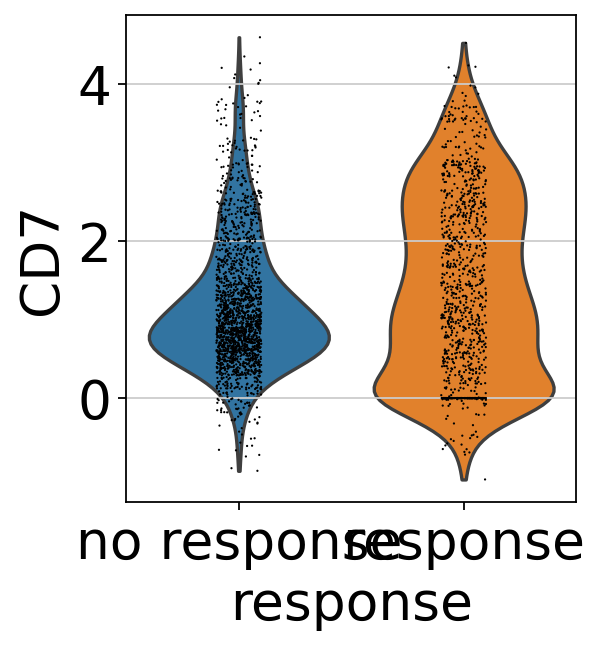

In [ ]:
sc.pl.violin(
    a_adata,
    keys=["CD7"],
    groupby="response"
)

In [ ]:
degs.loc["TOX"]
res_cd7 = a_adata[a_adata.obs["response"] == "response", "CD7"].X.ravel().mean()
res_tox = a_adata[a_adata.obs["response"] == "response", "TOX"].X.ravel().mean()

nes_cd7 = a_adata[a_adata.obs["response"] == "no response", "CD7"].X.ravel().mean()
nes_tox = a_adata[a_adata.obs["response"] == "no response", "TOX"].X.ravel().mean()

In [ ]:
res_cd7

ArrayView(1.4029056, dtype=float32)

In [ ]:
nes_cd7

ArrayView(1.1765714, dtype=float32)

In [ ]:
res_tox

ArrayView(0.09944218, dtype=float32)

In [ ]:
nes_tox

ArrayView(0.11932673, dtype=float32)

In [ ]:
degs[~degs.logfold.isna()].shape

(1423, 2)